<a href="https://colab.research.google.com/github/Zardian18/CGAN_custom_food10/blob/master/CGAN_rgb_food.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://raw.githubusercontent.com/Zardian18/helper-functions-colab/master/helper.py

--2024-02-09 07:43:56--  https://raw.githubusercontent.com/Zardian18/helper-functions-colab/master/helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17171 (17K) [text/plain]
Saving to: ‘helper.py’

helper.py           100%[===================>]  16.77K  --.-KB/s    in 0.001s  

2024-02-09 07:43:56 (21.2 MB/s) - ‘helper.py’ saved [17171/17171]



In [2]:
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.cifar10 import load_data
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Concatenate
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks, utils, metrics, losses, optimizers
from helper import sample_batch, display
import pandas as pd
import numpy as np
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
from PIL import Image
from keras.datasets import fashion_mnist
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot as plt

In [ ]:
# (trainX, trainy), (testX, testy) = load_data()

# # plot 25 images
# for i in range(25):
# 	plt.subplot(5, 5, 1 + i)
# 	plt.axis('off')
# 	plt.imshow(trainX[i])
# plt.show()

In [ ]:
!pip install kaggle
from google.colab import drive
drive.mount("/content/drive")

In [4]:
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d kmader/food41

100% 5.30G/5.30G [00:59<00:00, 111MB/s] 
100% 5.30G/5.30G [00:59<00:00, 96.2MB/s]


In [ ]:
!unzip food41.zip

In [7]:
food_items = [
    "apple_pie", "baby_back_ribs", "baklava", "beef_carpaccio", "beef_tartare",
    "beet_salad", "beignets", "bibimbap", "bread_pudding", "breakfast_burrito",
    "bruschetta", "caesar_salad", "cannoli", "caprese_salad", "carrot_cake",
    "ceviche", "cheesecake", "cheese_plate", "chicken_curry", "chicken_quesadilla",
    "chicken_wings","chocolate_mousse", "churros", "clam_chowder", "club_sandwich", "crab_cakes",
    "creme_brulee", "croque_madame", "cup_cakes", "deviled_eggs", "donuts",
    "dumplings", "edamame", "eggs_benedict", "escargots", "falafel", "filet_mignon",
    "fish_and_chips", "foie_gras", "french_onion_soup", "french_toast",
    "fried_calamari", "frozen_yogurt", "garlic_bread", "gnocchi", "greek_salad",
    "grilled_cheese_sandwich", "grilled_salmon", "guacamole", "gyoza",
    "hot_and_sour_soup", "hot_dog", "huevos_rancheros", "hummus", "lasagna",
    "lobster_bisque", "lobster_roll_sandwich", "macaroni_and_cheese", "macarons",
    "miso_soup", "mussels", "nachos", "omelette", "onion_rings", "oysters",
    "pad_thai", "paella", "pancakes", "panna_cotta", "peking_duck", "pho",
    "pork_chop", "poutine", "prime_rib", "pulled_pork_sandwich", "ravioli",
    "red_velvet_cake", "risotto", "sashimi", "scallops", "seaweed_salad",
    "shrimp_and_grits", "spaghetti_carbonara", "spring_rolls", "steak",
    "strawberry_shortcake", "sushi", "tacos", "takoyaki", "tiramisu",
    "tuna_tartare"
]

for directory in food_items:
  !rm -rf /content/images/{directory}

In [8]:
train_data = utils.image_dataset_from_directory(
    "/content/images/",
    color_mode= "rgb",
    image_size=(64,64),
    batch_size=128,
    shuffle = False,
    seed=42,
    interpolation= "bilinear"
)
train_data

Found 10000 files belonging to 10 classes.


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

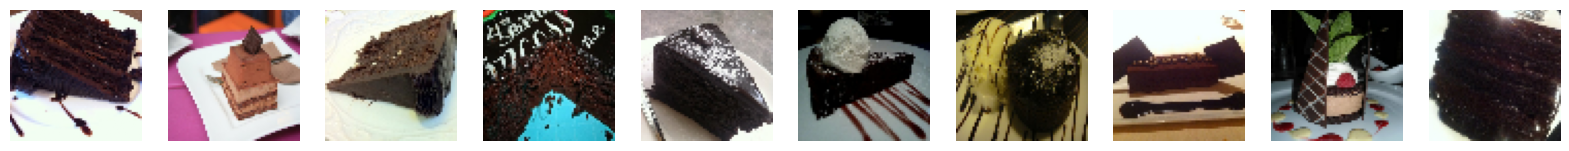

In [9]:
display(sample_batch(train_data))

In [10]:
def preprocess(imgs,y):
  imgs = (tf.cast(imgs, "float32")-127.5)/127.5
  return imgs,y

train = train_data.map(lambda x,y: preprocess(x,y))

In [11]:
train

<_MapDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [13]:
num_classes = 10

def separate_and_return_label(image, label):
    return image, label

original_label_dataset = train.map(separate_and_return_label)

input_images_dataset = original_label_dataset.map(lambda x, _: x)
original_labels_dataset = original_label_dataset.map(lambda _, y: y)

In [14]:
input_images_dataset

<_MapDataset element_spec=TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None)>

In [15]:
original_labels_dataset

<_MapDataset element_spec=TensorSpec(shape=(None,), dtype=tf.int32, name=None)>

In [16]:
input_images_array = np.concatenate(list(input_images_dataset))
labels_array = np.concatenate(list(original_labels_dataset))

In [17]:
from sklearn.utils import shuffle
input_images_array, labels_array = shuffle(input_images_array, labels_array)

In [18]:
trainX = tf.convert_to_tensor(input_images_array)
trainy = tf.convert_to_tensor(labels_array)

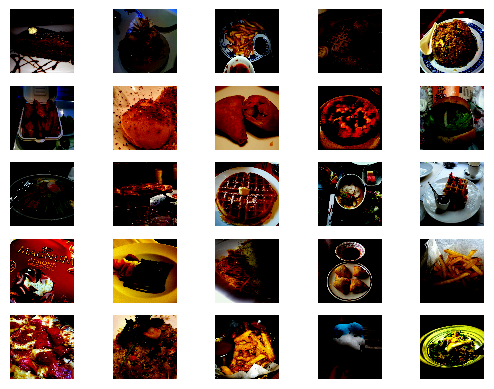

In [19]:
for i in range(25):
	plt.subplot(5, 5, 1 + i)
	plt.axis('off')
	plt.imshow(trainX[i])
plt.show()

In [30]:
import random
def show_random_samples_with_labels(trainX, trainy, label=None):
  if label == None:
    label = random.randint(0,9)
  index=[]
  for i in range(len(trainy)):
    if trainy[i] == label:
      index.append(i)

  index_final = random.choice(index)
  plt.imshow(trainX[index_final])
  plt.title(f"Label: {label}")
  plt.axis(False);

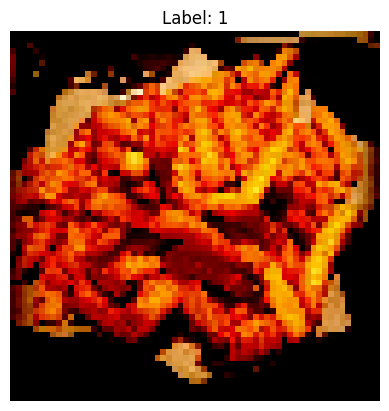

In [32]:
show_random_samples_with_labels(trainX, trainy, 1)

In [70]:
def define_discriminator(in_shape=(64,64,3), n_classes=10):

	in_label = Input(shape=(1,))
	li = Embedding(n_classes, 50)(in_label)
	n_nodes = in_shape[0] * in_shape[1]
	li = Dense(n_nodes)(li)
	li = Reshape((in_shape[0], in_shape[1], 1))(li)


	# image input
	in_image = Input(shape=in_shape)
	merge = Concatenate()([in_image, li])

	# downsample: This part is same as unconditional GAN upto the output layer.
    #We will combine input label with input image and supply as inputs to the model.

	fe = Conv2D(64, (3,3), strides=(2,2), padding='same')(merge) #16x16x128
	fe = LeakyReLU(alpha=0.2)(fe)

	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe) #16x16x128
	fe = LeakyReLU(alpha=0.2)(fe)

	fe = Conv2D(256, (3,3), strides=(2,2), padding='same')(fe) #16x16x128
	fe = LeakyReLU(alpha=0.2)(fe)
	# downsample
	fe = Conv2D(512, (3,3), strides=(2,2), padding='same')(fe) #8x8x128
	fe = LeakyReLU(alpha=0.2)(fe)
	# flatten feature maps
	fe = Flatten()(fe)  #8192  (8*8*128=8192)
	# dropout
	fe = Dropout(0.4)(fe)
	# output
	out_layer = Dense(1, activation='sigmoid')(fe)  #Shape=1

	# define model
    ##Combine input label with input image and supply as inputs to the model.
	model = Model([in_image, in_label], out_layer)
	# compile model
	opt = Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

In [71]:
disc= define_discriminator()
disc.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 embedding_5 (Embedding)     (None, 1, 50)                500       ['input_11[0][0]']            
                                                                                                  
 dense_10 (Dense)            (None, 1, 4096)              208896    ['embedding_5[0][0]']         
                                                                                                  
 input_12 (InputLayer)       [(None, 64, 64, 3)]          0         []                            
                                                                                            

In [72]:
def define_generator(latent_dim, n_classes=10):

	# label input
	in_label = Input(shape=(1,))  #Input of dimension 1
	# embedding for categorical input
    #each label (total 10 classes for cifar), will be represented by a vector of size 50.
	li = Embedding(n_classes, 50)(in_label) #Shape 1,50

	# linear multiplication
	n_nodes = 4 * 4  # To match the dimensions for concatenation later in this step.
	li = Dense(n_nodes)(li) #1,64
	# reshape to additional channel
	li = Reshape((4, 4, 1))(li)


	# image generator input
	in_lat = Input(shape=(latent_dim,))  #Input of dimension 100

	# foundation for 8x8 image
    # We will reshape input latent vector into 8x8 image as a starting point.
    #So n_nodes for the Dense layer can be 128x8x8 so when we reshape the output
    #it would be 8x8x128 and that can be slowly upscaled to 32x32 image for output.
    #Note that this part is same as unconditional GAN until the output layer.
    #While defining model inputs we will combine input label and the latent input.
	n_nodes = 512 * 4 * 4
	gen = Dense(n_nodes)(in_lat)  #shape=8192
	gen = LeakyReLU(alpha=0.2)(gen)
	gen = Reshape((4, 4, 512))(gen) #Shape=8x8x128
	# merge image gen and label input
	merge = Concatenate()([gen, li])  #Shape=8x8x129 (Extra channel corresponds to the label)
	# upsample to 16x16
	gen = Conv2DTranspose(512, (4,4), strides=(2,2), padding='same')(merge) #16x16x128
	gen = LeakyReLU(alpha=0.2)(gen)
	# upsample to 32x32
	gen = Conv2DTranspose(256, (4,4), strides=(2,2), padding='same')(gen) #32x32x128
	gen = LeakyReLU(alpha=0.2)(gen)

	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen) #32x32x128
	gen = LeakyReLU(alpha=0.2)(gen)

	gen = Conv2DTranspose(64, (4,4), strides=(2,2), padding='same')(gen) #32x32x128
	gen = LeakyReLU(alpha=0.2)(gen)
	# output
	out_layer = Conv2D(3, (8,8), activation='tanh', padding='same')(gen) #32x32x3
	# define model
	model = Model([in_lat, in_label], out_layer)
	return model   #Model not compiled as it is not directly trained like the discriminator.

In [74]:
test_gen = define_generator(200, n_classes=10)
test_gen.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_16 (InputLayer)       [(None, 200)]                0         []                            
                                                                                                  
 input_15 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 dense_15 (Dense)            (None, 8192)                 1646592   ['input_16[0][0]']            
                                                                                                  
 embedding_7 (Embedding)     (None, 1, 50)                500       ['input_15[0][0]']            
                                                                                            

In [75]:
def define_gan(g_model, d_model):
	d_model.trainable = False  #Discriminator is trained separately. So set to not trainable.

    ## connect generator and discriminator...
	# first, get noise and label inputs from generator model
	gen_noise, gen_label = g_model.input  #Latent vector size and label size
	# get image output from the generator model
	gen_output = g_model.output  #32x32x3

	# generator image output and corresponding input label are inputs to discriminator
	gan_output = d_model([gen_output, gen_label])
	# define gan model as taking noise and label and outputting a classification
	model = Model([gen_noise, gen_label], gan_output)
	# compile model
	opt = Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

In [ ]:
# def load_real_samples():
# 	# load dataset
# 	(trainX, trainy), (_, _) = load_data()   #cifar
# 	# convert to floats and scale
# 	X = trainX.astype('float32')
# 	# scale from [0,255] to [-1,1]
# 	X = (X - 127.5) / 127.5   #Generator uses tanh activation so rescale
#                             #original images to -1 to 1 to match the output of generator.
# 	return [X, trainy]

In [76]:
def generate_real_samples(dataset, n_samples):
	# split into images and labels
	images, labels = dataset
	# choose random instances
	ix = randint(0, images.shape[0], n_samples)
	# select images and labels
	X, labels = images[ix], labels[ix]
	# generate class labels and assign to y (don't confuse this with the above labels that correspond to cifar labels)
	y = ones((n_samples, 1))  #Label=1 indicating they are real
	return [X, labels], y

In [77]:
def generate_latent_points(latent_dim, n_samples, n_classes=10):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	# generate labels
	labels = randint(0, n_classes, n_samples)
	return [z_input, labels]

In [78]:
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	z_input, labels_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	images = generator.predict([z_input, labels_input])
	# create class labels
	y = zeros((n_samples, 1))  #Label=0 indicating they are fake
	return [images, labels_input], y

In [80]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=200, n_batch=128):
	bat_per_epo = int(dataset[0].shape[0] / n_batch)
	half_batch = int(n_batch / 2)  #the discriminator model is updated for a half batch of real samples
                            #and a half batch of fake samples, combined a single batch.
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):

             # Train the discriminator on real and fake images, separately (half batch each)
        #Research showed that separate training is more effective.
			# get randomly selected 'real' samples
            # get randomly selected 'real' samples
			[X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)

            # update discriminator model weights
            ##train_on_batch allows you to update weights based on a collection
            #of samples you provide
			d_loss_real, _ = d_model.train_on_batch([X_real, labels_real], y_real)

			# generate 'fake' examples
			[X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
			d_loss_fake, _ = d_model.train_on_batch([X_fake, labels], y_fake)

            #d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) #Average loss if you want to report single..

			# prepare points in latent space as input for the generator
			[z_input, labels_input] = generate_latent_points(latent_dim, n_batch)

            # The generator wants the discriminator to label the generated samples
        # as valid (ones)
        #This is where the generator is trying to trick discriminator into believing
        #the generated image is true (hence value of 1 for y)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
             # Generator is part of combined model where it got directly linked with the discriminator
        # Train the generator with latent_dim as x and 1 as y.
        # Again, 1 as the output as it is adversarial and if generator did a great
        #job of folling the discriminator then the output would be 1 (true)
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
			# Print losses on this batch
			print('Epoch>%d, Batch%d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss_real, d_loss_fake, g_loss))
	# save the generator model
	g_model.save('food10b.keras')


In [81]:
latent_dim = 200
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
# dataset = load_real_samples()

In [46]:
trainy[:5]

<tf.Tensor: shape=(5,), dtype=int32, numpy=array([0, 9, 1, 9, 2], dtype=int32)>

In [ ]:
train(g_model, d_model, gan_model, [input_images_array, labels_array], latent_dim, n_epochs=100)

In [83]:
def display_batch(
    images, n=10, size=(20, 3), cmap="gray_r", as_type="float32", save_to=None
):
    """
    Displays n random images from each one of the supplied arrays.
    """
    if images.max() > 1.0:
        images = images / 255.0
    elif images.min() < 0.0:
        images = (images + 1.0) / 2.0

    plt.figure(figsize=size)
    for i in range(n):
        _ = plt.subplot(1, n, i + 1)
        plt.imshow(images[i].astype(as_type), cmap=cmap)
        plt.axis("off")

    if save_to:
        plt.savefig(save_to)
        print(f"\nSaved to {save_to}")

    plt.show()

In [84]:
from numpy.random import randn, randint

def generate_latent_points_labels(latent_dim, n_samples, custom_labels=None, n_classes=10):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)

    if custom_labels is not None:
        # Use custom labels if provided
        labels = custom_labels[:n_samples]
    else:
        # generate random labels
        labels = randint(0, n_classes, n_samples)

    return [z_input, labels]


4/4 [==============================] - 1s 262ms/step


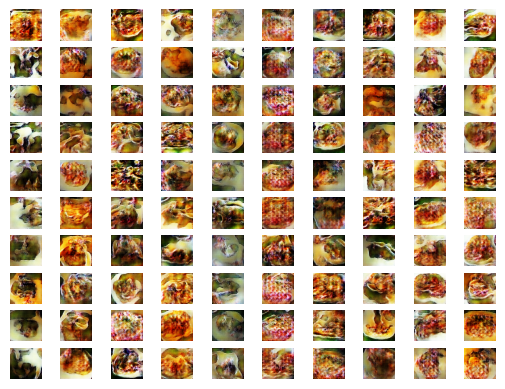

In [86]:
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from keras.models import load_model
import numpy as np
#

#Note: CIFAR10 classes are: airplane, automobile, bird, cat, deer, dog, frog, horse,
# ship, truck

# load model
model = load_model('food10b.keras')

# generate multiple images

latent_points, labels = generate_latent_points(200, 100)
# specify labels - generate 10 sets of labels each gping from 0 to 9
labels = asarray([x for _ in range(10) for x in range(10)])
# generate images
X  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
X = (X*255).astype(np.uint8)
# plot the result (10 sets of images, all images in a column should be of same class in the plot)
# Plot generated images
def show_plot(examples, n):
	for i in range(n * n):
		plt.subplot(n, n, 1 + i)
		plt.axis('off')
		plt.imshow(examples[i, :, :, :])
	plt.show()

show_plot(X, 10)

In [51]:
z_sample = np.random.normal(size=(10, 100))

In [52]:
latent_points, labels = generate_latent_points(100, 10)

In [ ]:
# from numpy import asarray
# from numpy.random import randn
# from keras.models import load_model
# import numpy as np
# import matplotlib.pyplot as plt

# # Function to generate latent points with specified labels
# def generate_latent_points(latent_dim, label_index, n_samples_per_class=10):
#     # generate points in the latent space
#     x_input = randn(latent_dim * n_samples_per_class)
#     # reshape into a batch of inputs for the network
#     z_input = x_input.reshape(n_samples_per_class, latent_dim)

#     # generate labels for the specified index
#     labels = [label_index] * n_samples_per_class

#     return [z_input, asarray(labels)]

# # Function to generate and display images for a specific label index
# def generate_and_display_images(model, latent_dim, label_index, n_samples_per_class=10):
#     latent_points, labels = generate_latent_points(latent_dim, label_index, n_samples_per_class)
#     # generate images
#     generated_images = model.predict([latent_points, labels])
#     # scale from [-1,1] to [0,1]
#     generated_images = (generated_images + 1) / 2.0

#     display_batch(generated_images, n=n_samples_per_class, size=(15, 3))

# # Function to display a batch of images
# def display_batch(images, n=10, size=(20, 3), cmap="gray_r", as_type="float32", save_to=None):
#     if images.max() > 1.0:
#         images = images / 255.0
#     elif images.min() < 0.0:
#         images = (images + 1.0) / 2.0

#     plt.figure(figsize=size)
#     for i in range(n):
#         _ = plt.subplot(1, n, i + 1)
#         plt.imshow(images[i].astype(as_type), cmap=cmap)
#         plt.axis("off")

#     if save_to:
#         plt.savefig(save_to)
#         print(f"\nSaved to {save_to}")

#     plt.show()

# # load model
# model = load_model('cifar_conditional_generator_25epochs.h5')

In [53]:
model = load_model('food10b.keras')

In [54]:
z_sample = np.random.normal(size=(10, 100))

In [55]:
z_sample.shape

(10, 100)

In [101]:
from numpy import asarray
from numpy.random import randn
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt

# Function to generate and display images for multiple latent vectors with a specific label index
def generate_and_display_images_row(model, latent_vectors, label_index):
    n_samples = len(latent_vectors)
    latent_points = np.array(latent_vectors).reshape(n_samples, -1)
    labels = [label_index] * n_samples

    # generate images
    generated_images = model.predict([latent_points, asarray(labels)])
    # scale from [-1,1] to [0,1]
    generated_images = (generated_images + 1) / 2.0

    display_batch(generated_images, n=n_samples, size=(15, 3))

# Example usage:
latent_dim = 200
specified_latent_vectors = [np.random.randn(latent_dim) for _ in range(10)]

## Label 0

1/1 [==============================] - 0s 225ms/step


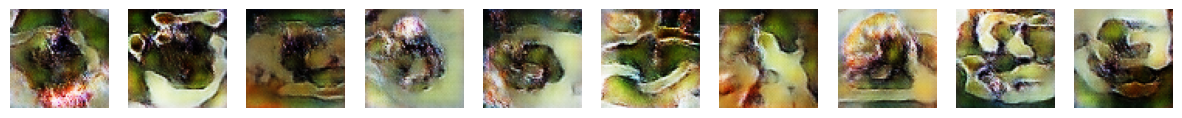

In [119]:
label_index = 0
specified_latent_vectors = [np.random.randn(latent_dim) for _ in range(10)]
generate_and_display_images_row(model, specified_latent_vectors, label_index)

## Label 1

1/1 [==============================] - 0s 24ms/step


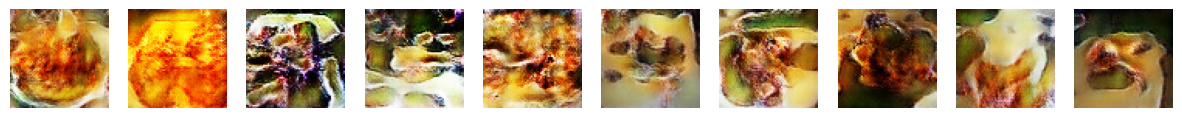

In [120]:
label_index = 1
specified_latent_vectors = [np.random.randn(latent_dim) for _ in range(10)]
generate_and_display_images_row(model, specified_latent_vectors, label_index)

## Label 2

1/1 [==============================] - 0s 47ms/step


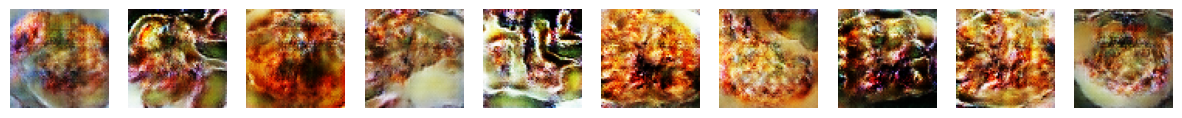

In [121]:
label_index = 2
specified_latent_vectors = [np.random.randn(latent_dim) for _ in range(10)]
generate_and_display_images_row(model, specified_latent_vectors, label_index)

## Label 3

1/1 [==============================] - 0s 39ms/step


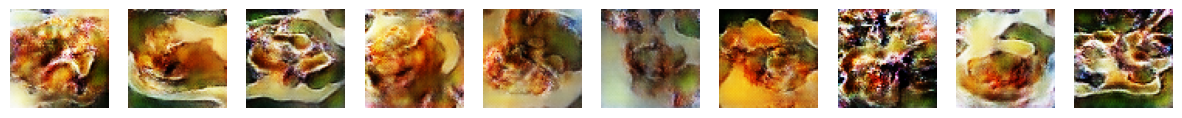

In [122]:
label_index = 3
specified_latent_vectors = [np.random.randn(latent_dim) for _ in range(10)]
generate_and_display_images_row(model, specified_latent_vectors, label_index)

## Label 4

1/1 [==============================] - 0s 42ms/step


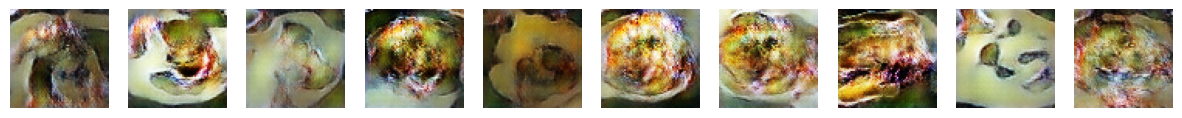

In [124]:
label_index = 4
specified_latent_vectors = [np.random.randn(latent_dim) for _ in range(10)]
generate_and_display_images_row(model, specified_latent_vectors, label_index)

## Label 5

1/1 [==============================] - 0s 43ms/step


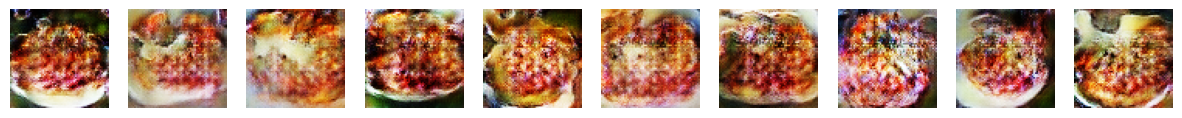

In [126]:
label_index = 5
specified_latent_vectors = [np.random.randn(latent_dim) for _ in range(10)]
generate_and_display_images_row(model, specified_latent_vectors, label_index)

## Label 6

1/1 [==============================] - 0s 40ms/step


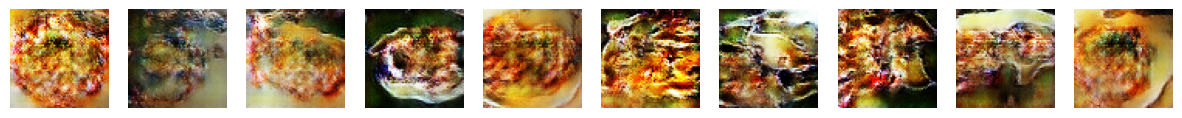

In [127]:
label_index = 6
specified_latent_vectors = [np.random.randn(latent_dim) for _ in range(10)]
generate_and_display_images_row(model, specified_latent_vectors, label_index)

## Label 7

1/1 [==============================] - 0s 37ms/step


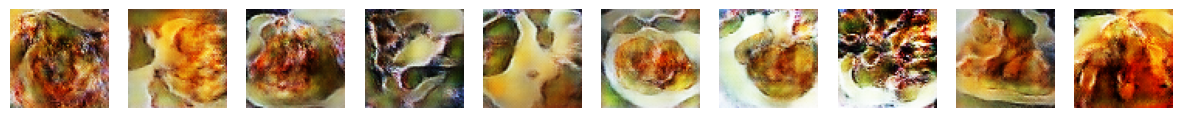

In [128]:
label_index = 7
specified_latent_vectors = [np.random.randn(latent_dim) for _ in range(10)]
generate_and_display_images_row(model, specified_latent_vectors, label_index)

## Label 8

1/1 [==============================] - 0s 42ms/step


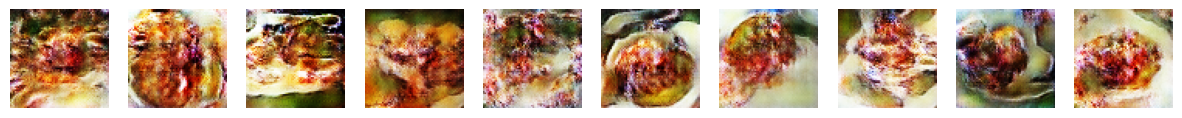

In [129]:
label_index = 8
specified_latent_vectors = [np.random.randn(latent_dim) for _ in range(10)]
generate_and_display_images_row(model, specified_latent_vectors, label_index)

## Label 9

1/1 [==============================] - 0s 54ms/step


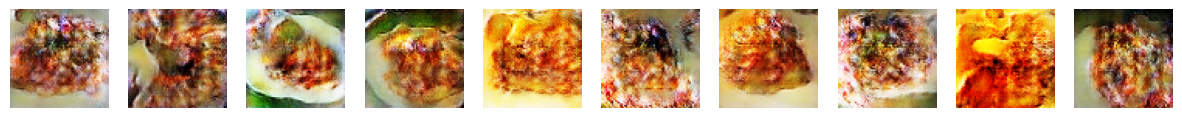

In [130]:
label_index = 9
specified_latent_vectors = [np.random.randn(latent_dim) for _ in range(10)]
generate_and_display_images_row(model, specified_latent_vectors, label_index)

1/1 [==============================] - 0s 26ms/step


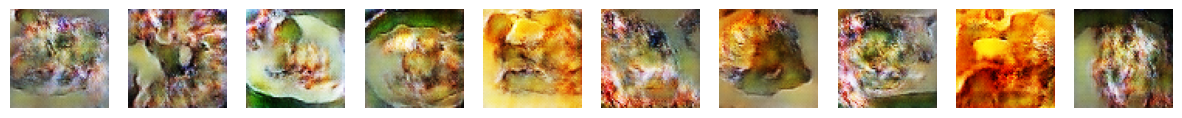

In [131]:
label_index = 4
generate_and_display_images_row(model, specified_latent_vectors, label_index)